In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import requests
import time
import math
import itertools
import sys
from sklearn.linear_model import LinearRegression

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [2]:
npd = pd.read_csv('./../Preprocess/data/ANP2.2_NPD_data.csv',delimiter=';', skiprows=[0])


In [92]:
# npd = npd[ (npd.NPD_ID == 'CF567B') & (npd["Op Mode"]=='D')]
npd = npd.query('NPD_ID == "CF567B" and `Op Mode` == "D" and `Noise Metric` == "LAmax" ')
npd

,NPD_ID,Noise Metric,Op Mode,Power Setting,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
811,CF567B,LAmax,D,10000.0,95.2,87.9,83.6,78.8,71.3,63.0,57.3,50.4,44.2,36.9
812,CF567B,LAmax,D,13000.0,98.1,91.0,86.7,82.0,74.5,66.3,60.7,53.9,46.9,39.6
813,CF567B,LAmax,D,16000.0,100.5,93.7,89.3,84.6,77.3,69.2,63.5,56.8,49.4,42.1
814,CF567B,LAmax,D,19000.0,102.7,96.0,91.7,87.1,79.7,71.7,66.1,59.5,52.2,44.9
815,CF567B,LAmax,D,23500.0,107.2,100.9,96.5,91.9,84.7,76.8,71.4,64.6,57.7,50.4


In [93]:
npd.set_index('Power Setting', inplace=True)
npd = npd.drop(columns=['NPD_ID','Noise Metric','Op Mode']).T.reset_index()
npd.rename(columns={'index':'distance'},inplace=True)

In [94]:
def get_feet(distance):
    feet = distance.split('_')[1]
    return float(feet[:-2])
npd['distance'] = npd['distance'].apply(get_feet)

In [95]:
npd.columns = [str(col) for col in npd.columns]
npd

,distance,10000.0,13000.0,16000.0,19000.0,23500.0
0,200.0,95.2,98.1,100.5,102.7,107.2
1,400.0,87.9,91.0,93.7,96.0,100.9
2,630.0,83.6,86.7,89.3,91.7,96.5
3,1000.0,78.8,82.0,84.6,87.1,91.9
4,2000.0,71.3,74.5,77.3,79.7,84.7
5,4000.0,63.0,66.3,69.2,71.7,76.8
6,6300.0,57.3,60.7,63.5,66.1,71.4
7,10000.0,50.4,53.9,56.8,59.5,64.6
8,16000.0,44.2,46.9,49.4,52.2,57.7
9,25000.0,36.9,39.6,42.1,44.9,50.4


In [96]:
x = npd['distance'].values.reshape(-1, 1)
y = npd['10000.0'].values.reshape(-1, 1)


In [97]:
x

array([[  200.],
       [  400.],
       [  630.],
       [ 1000.],
       [ 2000.],
       [ 4000.],
       [ 6300.],
       [10000.],
       [16000.],
       [25000.]])

In [98]:
x_inv_square = 1 / (x**2)
x_transformed = np.c_[x, x_inv_square]

In [99]:
x_transformed

array([[2.00000000e+02, 2.50000000e-05],
       [4.00000000e+02, 6.25000000e-06],
       [6.30000000e+02, 2.51952633e-06],
       [1.00000000e+03, 1.00000000e-06],
       [2.00000000e+03, 2.50000000e-07],
       [4.00000000e+03, 6.25000000e-08],
       [6.30000000e+03, 2.51952633e-08],
       [1.00000000e+04, 1.00000000e-08],
       [1.60000000e+04, 3.90625000e-09],
       [2.50000000e+04, 1.60000000e-09]])

In [100]:
# x_log = np.log(y)
# x_transformed = np.c_[x, x_log]


In [101]:
reg = LinearRegression().fit(x_transformed, y)
# reg = LinearRegression().fit(x_inv_square, y)
# reg = LinearRegression().fit(x_log,y)



In [102]:
x_pred = 30000
# x_pred = np.array([200,500,630.0, 1000.0,2000.0, 4000.0,6300.0,10000, 15000, 30000,50000]).reshape(-1, 1)
# x_pred = npd['distance'].values.reshape(-1, 1)

x_pred_inv_square = 1 / (x_pred**2)
x_pred_transformed = np.c_[x_pred, x_pred_inv_square]
y_pred = reg.predict(x_pred_transformed)
# y_pred = reg.predict(x_pred_inv_square)

# x_log_pred = reg.predict(x_pred)
# y_pred = np.exp(x_log_pred)



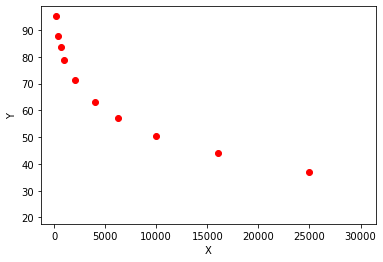

In [103]:
plt.scatter(x, y, color='red')
plt.plot(x_pred, y_pred, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [111]:
y_pred

array([[21.30992582]])

In [105]:
reg.coef_

array([[-1.80637485e-03,  9.10240933e+05]])

In [106]:
reg.intercept_

array([75.50015993])

In [107]:
x_inv_square

array([[2.50000000e-05],
       [6.25000000e-06],
       [2.51952633e-06],
       [1.00000000e-06],
       [2.50000000e-07],
       [6.25000000e-08],
       [2.51952633e-08],
       [1.00000000e-08],
       [3.90625000e-09],
       [1.60000000e-09]])

In [108]:
x_inv_square*reg.coef_[0][0] +reg.intercept_

array([[75.50015989],
       [75.50015992],
       [75.50015993],
       [75.50015993],
       [75.50015993],
       [75.50015993],
       [75.50015993],
       [75.50015993],
       [75.50015993],
       [75.50015993]])

In [109]:
reg.coef_[0]

array([-1.80637485e-03,  9.10240933e+05])

In [110]:
y

array([[95.2],
       [87.9],
       [83.6],
       [78.8],
       [71.3],
       [63. ],
       [57.3],
       [50.4],
       [44.2],
       [36.9]])

# NPD -> firestore

In [7]:
# cred = credentials.Certificate('./../Backend/serviceAccount.json')
# app_firebase = firebase_admin.initialize_app(cred)
# db = firestore.client()

In [5]:
npd

,NPD_ID,Noise Metric,Op Mode,Power Setting,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
0,2CF650,EPNL,A,10000.0,106.2,101.1,97.2,92.5,84.2,75.0,68.0,61.4,53.4,43.3
1,2CF650,EPNL,A,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
2,2CF650,EPNL,D,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
3,2CF650,EPNL,D,40000.0,113.0,108.6,105.2,101.5,95.6,88.2,83.1,77.5,70.8,63.3
4,2CF650,LAmax,A,10000.0,99.2,91.9,86.7,81.0,72.1,63.0,56.7,49.6,41.6,33.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,7378MAX,EPNL,D,13000.0,100.8,96.4,93.1,89.3,82.8,75.6,70.2,64.1,57.9,52.0
2728,7378MAX,EPNL,D,16000.0,102.4,98.1,94.9,91.1,84.7,77.6,72.3,66.3,60.2,54.5
2729,7378MAX,EPNL,D,19000.0,103.6,99.4,96.3,92.6,86.4,79.5,74.3,68.5,62.5,56.9
2730,7378MAX,EPNL,D,22000.0,104.5,100.4,97.4,93.9,88.0,81.4,76.4,70.6,64.9,59.5


In [8]:
doc_ref = db.collection(f'ANP_sound')

In [11]:
postdata = npd.to_dict('records')
# postdata

In [12]:
list(map(lambda x: doc_ref.add(x), postdata))
print('insert success')

insert success


In [14]:
df_fixpoint = pd.read_csv('./../Preprocess/data/ANP2.2_Default_fixed_point_profiles.csv',delimiter=';', skiprows=[0])
df_fixpoint.head()

,ACFT_ID,Op Type,Profile_ID,Stage Length,Point Number,Distance (ft),Altitude AFE (ft),TAS (kt),Power Setting
0,707,A,DEFAULT,1,1,-114487.0,6000.0,250.0,600.0
1,707,A,DEFAULT,1,2,-57243.0,3000.0,124.0,3560.0
2,707,A,DEFAULT,1,3,-28622.0,1500.0,124.0,3585.0
3,707,A,DEFAULT,1,4,-19081.0,1000.0,124.0,3585.0
4,707,A,DEFAULT,1,5,0.0,0.0,124.0,3585.0


In [15]:
doc_ref2 = db.collection(f'fixed_point_profiles')


In [17]:
postdata2 = df_fixpoint.to_dict('records')
# postdata2

In [18]:
list(map(lambda x: doc_ref2.add(x), postdata2))
print('insert success')

insert success


# read firestore

In [19]:
docs = list(doc_ref.stream())
flight_dict = list(map(lambda x: x.to_dict(), docs))

In [21]:
pd.DataFrame(flight_dict)

,Power Setting,Op Mode,L_25000ft,L_4000ft,L_1000ft,L_10000ft,Noise Metric,L_2000ft,L_16000ft,L_200ft,L_630ft,NPD_ID,L_6300ft,L_400ft
0,1899.0,D,50.9,70.9,80.4,62.6,SEL,75.9,57.1,89.7,83.2,PT6A114,67.1,85.8
1,10000.0,D,44.7,75.1,92.4,61.3,LAmax,84.2,53.3,109.2,97.5,3JT8E5,68.4,102.3
2,2000.0,A,43.9,67.4,79.9,56.9,SEL,74.1,50.7,90.9,83.3,CF34,62.4,86.7
3,5000.0,A,48.3,80.1,98.7,66.9,EPNL,89.5,58.9,113.3,103.8,JT3DQ,73.5,108.1
4,5200.0,A,58.7,80.4,92.1,70.3,SEL,86.8,64.4,102.3,95.4,AL502R,75.6,98.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,4250.0,A,28.2,54.6,71.6,41.6,LAmax,63.4,34.7,89.2,76.8,BR715,48.3,81.6
2728,2400.0,D,39.7,69.9,86.8,56.7,PNLTM,78.7,49.1,102.6,91.6,TIO540,63.6,96.0
2729,5000.0,D,32.3,61.9,78.6,48.7,LAmax,70.6,40.9,95.0,83.5,CF34,55.6,88.2
2730,6000.0,A,48.3,72.6,86.0,60.6,EPNL,79.9,54.3,98.0,89.9,7378MAX,66.9,93.3


In [22]:
npd

,NPD_ID,Noise Metric,Op Mode,Power Setting,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
0,2CF650,EPNL,A,10000.0,106.2,101.1,97.2,92.5,84.2,75.0,68.0,61.4,53.4,43.3
1,2CF650,EPNL,A,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
2,2CF650,EPNL,D,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
3,2CF650,EPNL,D,40000.0,113.0,108.6,105.2,101.5,95.6,88.2,83.1,77.5,70.8,63.3
4,2CF650,LAmax,A,10000.0,99.2,91.9,86.7,81.0,72.1,63.0,56.7,49.6,41.6,33.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,7378MAX,EPNL,D,13000.0,100.8,96.4,93.1,89.3,82.8,75.6,70.2,64.1,57.9,52.0
2728,7378MAX,EPNL,D,16000.0,102.4,98.1,94.9,91.1,84.7,77.6,72.3,66.3,60.2,54.5
2729,7378MAX,EPNL,D,19000.0,103.6,99.4,96.3,92.6,86.4,79.5,74.3,68.5,62.5,56.9
2730,7378MAX,EPNL,D,22000.0,104.5,100.4,97.4,93.9,88.0,81.4,76.4,70.6,64.9,59.5


In [23]:
docs = list(doc_ref2.stream())
flight_dict = list(map(lambda x: x.to_dict(), docs))


In [24]:
pd.DataFrame(flight_dict)

,Power Setting,ACFT_ID,Stage Length,TAS (kt),Distance (ft),Op Type,Point Number,Altitude AFE (ft),Profile_ID
0,22922.0,747100,6,250.0,156541.0,D,10,7500.0,DEFAULT
1,9108.0,707,5,250.0,147937.0,D,11,7500.0,DEFAULT
2,2700.0,CNA206,3,35.0,0.0,D,1,0.0,3600LB
3,6000.0,MD11PW,1,90.0,326.0,A,6,0.0,DEFAULT
4,4164.0,MD83,1,154.5,-48028.0,A,19,2520.0,DEFAULT
...,...,...,...,...,...,...,...,...,...
922,13120.0,707120,3,250.0,80205.0,D,10,10000.0,DEFAULT
923,3615.0,MD82,1,145.0,-9895.0,A,23,519.0,DEFAULT
924,11895.0,727200,4,210.0,41927.0,D,4,2296.0,DEFAULT
925,8680.0,MD83,1,142.0,372.6,A,26,0.0,DEFAULT


In [25]:
df_fixpoint

,ACFT_ID,Op Type,Profile_ID,Stage Length,Point Number,Distance (ft),Altitude AFE (ft),TAS (kt),Power Setting
0,707,A,DEFAULT,1,1,-114487.0,6000.0,250.0,600.0
1,707,A,DEFAULT,1,2,-57243.0,3000.0,124.0,3560.0
2,707,A,DEFAULT,1,3,-28622.0,1500.0,124.0,3585.0
3,707,A,DEFAULT,1,4,-19081.0,1000.0,124.0,3585.0
4,707,A,DEFAULT,1,5,0.0,0.0,124.0,3585.0
...,...,...,...,...,...,...,...,...,...
922,SABR80,D,DEFAULT,1,8,28342.0,3000.0,185.0,3428.1
923,SABR80,D,DEFAULT,1,9,51002.0,4492.0,267.3,3197.2
924,SABR80,D,DEFAULT,1,10,60166.0,5500.0,271.4,3184.5
925,SABR80,D,DEFAULT,1,11,80084.0,7500.0,279.8,3220.8
